In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

In [3]:
cd .. 

c:\Users\alaurent\source\repos\montinette


In [4]:
from montinette.sensors import CounterDataFrame

In [6]:
# Data from all sensors
df = pd.read_csv('./input/capteurs/Sensors.csv', sep=';')

# Divide data by sensors type
## Sensors for the vehicules which went in the parking lot
cdf_in_1 = CounterDataFrame(
    df[df['Entity Name'] == '034050780000000A'].copy(),
    datetime='Timestamp',
    counter='eventsCountA',
    name='Entity Name',
    timestamp=True
)
cdf_in_2 = CounterDataFrame(
    df[df['Entity Name'] == '034050780000000B'].copy(),
    datetime='Timestamp', 
    counter='eventsCountA', 
    name='Entity Name', 
    timestamp=True
)
## Sensors for the vehicules which leave the parking lot
cdf_out = CounterDataFrame(
    df[df['Entity Name'] == '034050780000000A'].copy(), 
    datetime='Timestamp', 
    counter='eventsCountB', 
    name='Entity Name', 
    timestamp=True
)

# Compute the hourly counts IN/OUT
## IN
ct_hr_in_1 = cdf_in_1.get_hour_counts(clean=True, reset_interval=1).copy()
ct_hr_in_2 = cdf_in_2.get_hour_counts(clean=True, reset_interval=1).copy()
## Aggregate data from multiple sensors
ct_hr_in = ct_hr_in_1.join(ct_hr_in_2, how='inner', lsuffix='_1', rsuffix='_2')
ct_hr_in['in'] = ct_hr_in.sum(axis=1)
## OUT
ct_hr_out = cdf_out.get_hour_counts(clean=True, reset_interval=1)
ct_hr_out['out'] = ct_hr_out.count_delta.copy()

# Join IN and OUT counts into one dataframe
ct_in_out = ct_hr_in.join(ct_hr_out, how='inner')[['in', 'out']]
ct_in_out = ct_in_out.reset_index()
ct_in_out['day_interval'] = ((ct_in_out['date'].dt.dayofyear +
                                ct_in_out['date'].dt.day.iloc[0]) //
                                1 - 
                            ct_in_out['date'].dt.day.iloc[0] // 1)

ct_in_out['year'] = ct_in_out.date.dt.year
ct_in_out['reset_interval'] = ct_in_out.year.astype(str) + ' ' + ct_in_out.day_interval.astype(str)
ct_in_out = ct_in_out.assign(
    reset_interval=ct_in_out.reset_interval.replace({ct_in_out.reset_interval.unique()[i]:i+1
                                                for i in range(len(ct_in_out.reset_interval.unique()))})
)
ct_in_out.drop(columns=['day_interval', 'year'], inplace=True)

ct_in_out['delta'] = ct_in_out['in'] - ct_in_out['out']
ct_in_out['nb_veh'] = ct_in_out.groupby('reset_interval')['delta'].cumsum()

Resets in counts have been detected. Column "reset" created.
Resets in counts have been detected. Column "reset" created.
Resets in counts have been detected. Column "reset" created.


AttributeError: 'DataFrame' object has no attribute 'day_interval'

In [6]:
ct_in_out = ct_in_out.reset_index().assign(date=lambda x: pd.to_datetime(x.date)).set_index(['date', 'hr'])

In [7]:
ct_in_out[: '2022-12-10'].describe().T

,count,mean,std,min,25%,50%,75%,max
index,762.0,380.500000,220.114743,0.0,190.25,380.5,570.75,761.0
in,762.0,28.538058,26.488224,0.0,10.00,23.0,37.00,200.0
out,762.0,29.022310,30.304296,0.0,7.00,21.0,40.00,205.0
reset_interval,762.0,15.173228,8.528004,1.0,8.00,15.0,23.00,30.0
delta,762.0,-0.484252,14.862060,-114.0,-6.00,0.0,5.00,76.0
nb_veh,762.0,11.132546,78.192505,-242.0,-31.75,14.0,53.00,273.0


Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-235.0, ..., 4835.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1015 ticks ([-2

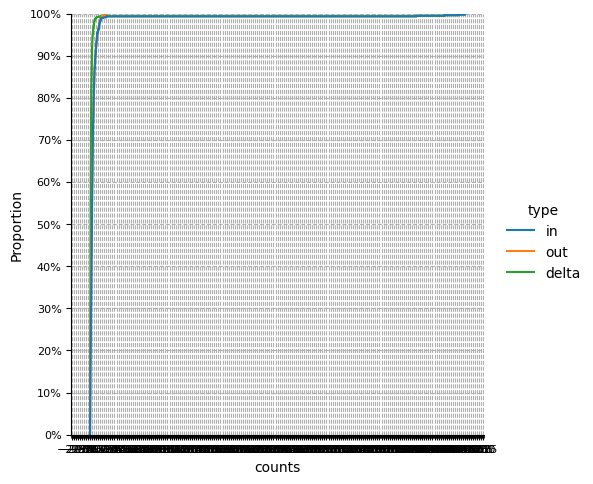

In [18]:
dt_from = '2022-11-10'#ct_in_out.sort_index().index[0][0].date().__str__()
dt_to = '2022-12-10'
sns.displot(
    data=(ct_in_out[dt_from:dt_to].assign(delta=lambda x: np.abs(x.delta))
                                  .melt(value_vars=['in', 'out', 'delta'], 
                                         value_name='counts', 
                                         var_name='type')),
    x='counts',
    hue='type',
    kind='ecdf'
)
ax = plt.gca()
ax.set_yticks(np.arange(0, 1.1, 0.1));
ax.set_yticklabels(np.char.add(np.arange(0, 110, 10).astype(str), '%'));
# define tick positions
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=8)
ax.grid(linestyle='--');

f = plt.gcf()
f.savefig(f'./output/distribution_comptage_par_heure_du_{dt_from}_au_{dt_to}.png', dpi=150)

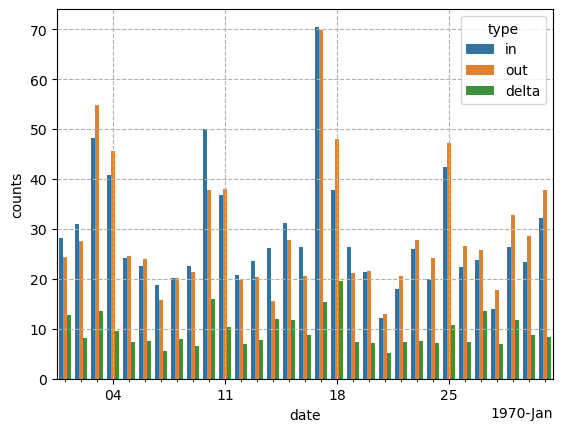

In [180]:
sns.barplot(
    data=(ct_in_out[dt_from:dt_to].assign(delta=lambda x: np.abs(x.delta))
                                  .groupby('date').mean()
                                  .reset_index()
                                  .melt(id_vars='date',
                                        value_vars=['in', 'out', 'delta'], 
                                        value_name='counts', 
                                        var_name='type')),
    x='date',
    y='counts',
    hue='type',
)
ax = plt.gca()
ax.set_xticks()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(linestyle='--');

f = plt.gcf()
f.savefig(f'./output/distribution_comptage_par_jour_{dt_from}_au_{dt_to}.png', dpi=150)

In [246]:
data

,date,hr,in,out,delta,charge,timestamp
0,2022-11-18,0,7.0,12.0,-5.0,-5.0,2022-11-18 00:00:00
1,2022-11-18,1,4.0,4.0,0.0,-5.0,2022-11-18 01:00:00
2,2022-11-18,2,4.0,5.0,-1.0,-6.0,2022-11-18 02:00:00
3,2022-11-18,3,2.0,1.0,1.0,-5.0,2022-11-18 03:00:00
4,2022-11-18,4,4.0,2.0,2.0,-3.0,2022-11-18 04:00:00
5,2022-11-18,5,4.0,2.0,2.0,-1.0,2022-11-18 05:00:00
6,2022-11-18,6,20.0,3.0,17.0,16.0,2022-11-18 06:00:00
7,2022-11-18,7,19.0,17.0,2.0,18.0,2022-11-18 07:00:00
8,2022-11-18,8,20.0,14.0,6.0,24.0,2022-11-18 08:00:00
9,2022-11-18,9,24.0,10.0,14.0,38.0,2022-11-18 09:00:00


In [20]:
import datetime

dt_from='2022-12-01'
dt_to='2022-12-31'
data = ct_in_out[dt_from:dt_to][['in', 'out', 'delta']].copy()
data['charge'] = data.delta.cumsum()
data = data.reset_index()
data['timestamp'] = data.date + data.hr.apply(lambda x: datetime.timedelta(hours=x))

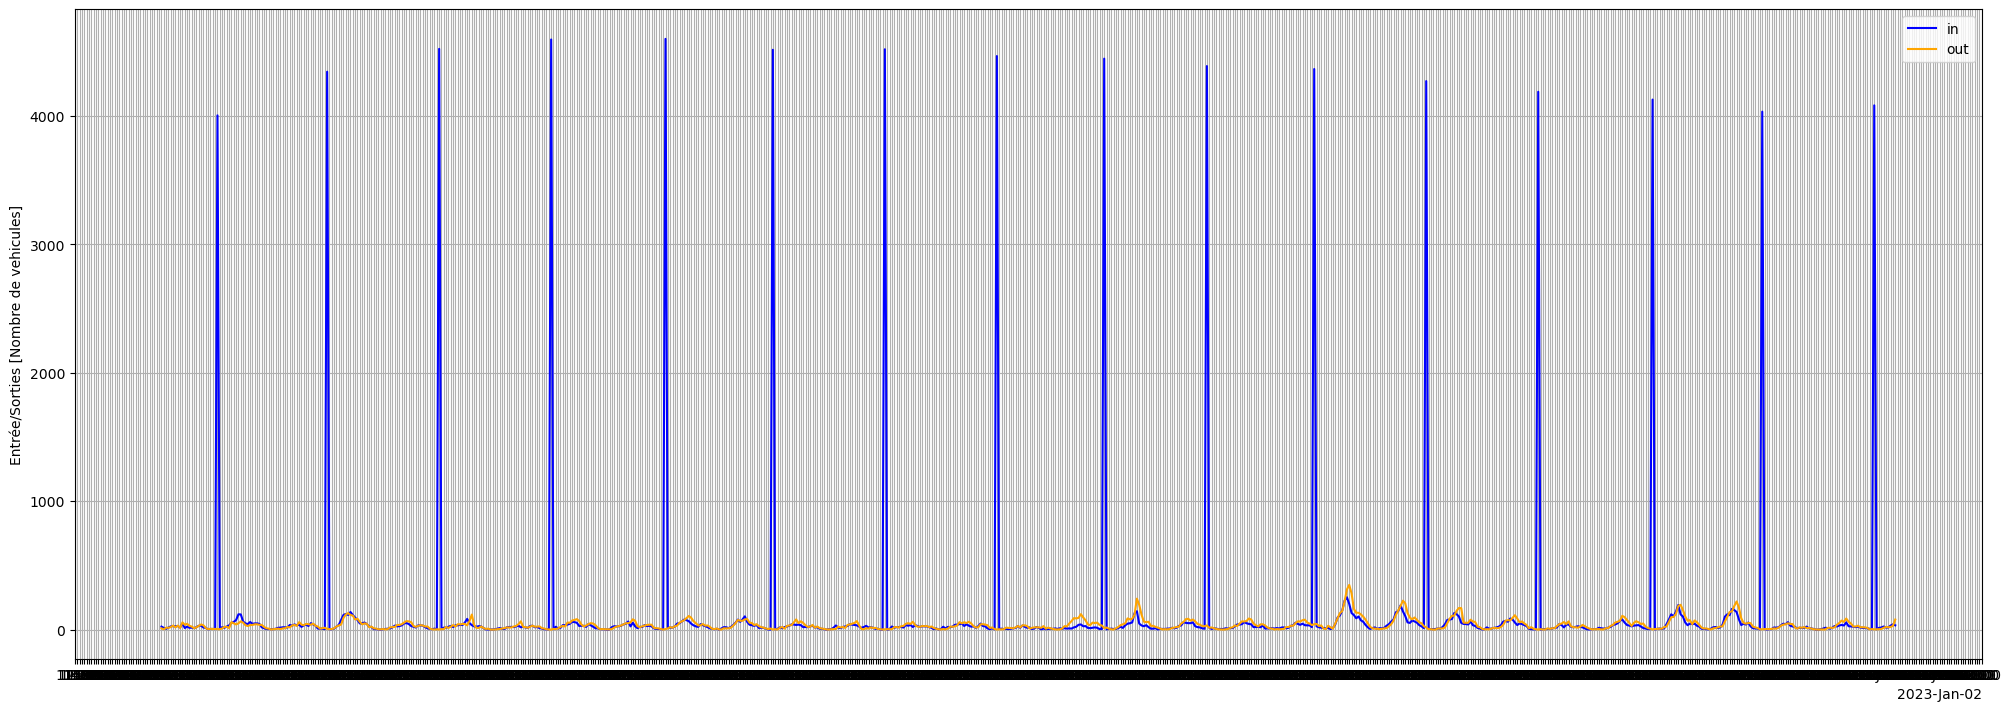

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7), constrained_layout=True)
ax.plot('timestamp', 'in', data=data, color='blue')
ax.plot('timestamp', 'out', data=data, color='orange')
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
ax.legend()
ax.set_ylabel(r'Entrée/Sorties [Nombre de vehicules]')
fig.savefig(f'./output/entrees_sorties_horraire_du_{dt_from}_au{dt_to}.png', dpi=250)

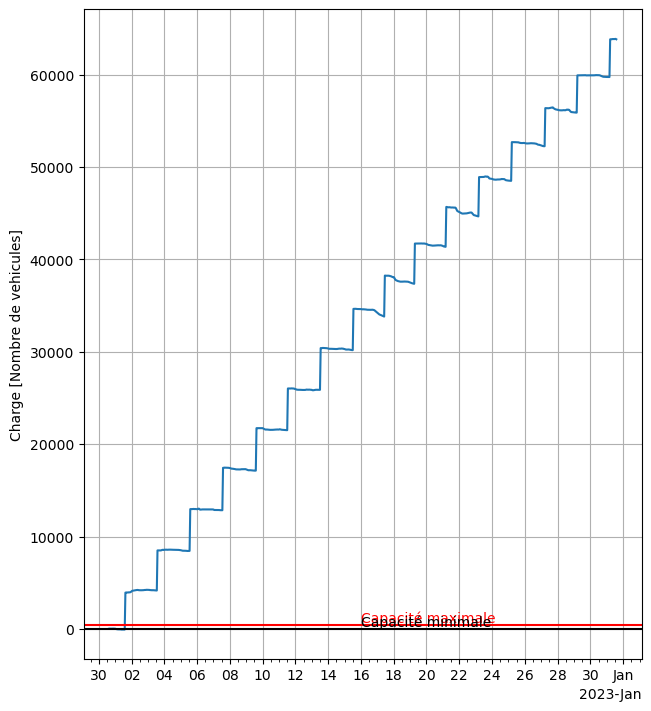

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6.4, 7), constrained_layout=True)
ax.plot('timestamp', 'charge', data=data)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
ax.set_ylabel(r'Charge [Nombre de vehicules]')

# Capacité max
plt.axhline(y=425, color='r', linestyle='-');
t = plt.text(ax.get_xticks()[8], 425, f'Capacité maximale', fontsize=10, color='r', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# Capacité min
plt.axhline(y=0, color='k', linestyle='-');
t = plt.text(ax.get_xticks()[8], 0, f'Capacité minimale', fontsize=10, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

fig.savefig(f'./output/distribution_charge_par_heure_{dt_from}_au_{dt_to}.png', dpi=150)
  

In [235]:
print(f"{np.round(np.count_nonzero((data.charge > 425) | (data.charge < 0)) / data.shape[0] * 100)}% des charges horraire sortent de la charge possible dans le stationnement.")

61.0% des charges horraire sortent de la charge possible dans le stationnement.


In [187]:
correction = np.abs(ct_in_out[dt_from:dt_to].delta.min())
corr_ax = np.zeros(ct_in_out.shape[0])
corr_ax[0] = correction
ct_in_out['delta_cor'] = ct_in_out.delta + corr_ax
ct_in_out['nb_veh_cor'] = ct_in_out.delta_cor.cumsum()

In [188]:
ct_in_out.loc['2022-11-09']

,in,out,delta,nb_veh,delta_cor,nb_veh_cor
hr,,,,,,
11,129.0,115.0,14.0,14.0,128.0,128.0
12,51.0,46.0,5.0,19.0,5.0,133.0
13,55.0,60.0,-5.0,14.0,-5.0,128.0
14,44.0,62.0,-18.0,-4.0,-18.0,110.0
15,64.0,85.0,-21.0,-25.0,-21.0,89.0
16,47.0,76.0,-29.0,-54.0,-29.0,60.0
17,22.0,38.0,-16.0,-70.0,-16.0,44.0
18,20.0,21.0,-1.0,-71.0,-1.0,43.0
19,36.0,23.0,13.0,-58.0,13.0,56.0


In [189]:
ct_in_out[dt_from:dt_to].

,count,mean,std,min,25%,50%,75%,max
in,744.0,28.631720,26.627713,0.0,10.0,23.0,37.0,200.0
out,744.0,29.056452,30.384074,0.0,7.0,21.0,40.0,205.0
delta,744.0,-0.424731,14.940789,-114.0,-6.0,0.0,5.0,76.0
nb_veh,744.0,254.877688,307.243915,-341.0,-38.0,212.0,561.0,918.0
delta_cor,744.0,-0.424731,14.940789,-114.0,-6.0,0.0,5.0,76.0
nb_veh_cor,744.0,368.877688,307.243915,-227.0,76.0,326.0,675.0,1032.0
